## The Data

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

### Visualizing the Data


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [11]:
my_data_dir ="C:\\Users\\Yasser B\\Desktop\\Tf2\\TF_2_Notebooks_and_Data\\cell_images\\cell_images"

In [12]:
os.listdir(my_data_dir) 

['test', 'train']

In [13]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [14]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [15]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [20]:
os.listdir(train_path+'\\parasitized')[10]

'C100P61ThinF_IMG_20150918_144348_cell_138.png'

In [26]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144348_cell_138.png'

In [27]:
para_img= imread(para_cell)

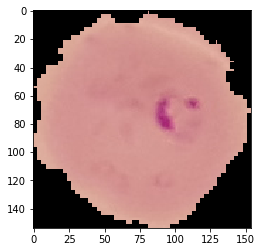

In [28]:
plt.imshow(para_img)

In [29]:
para_img.shape

(154, 154, 3)

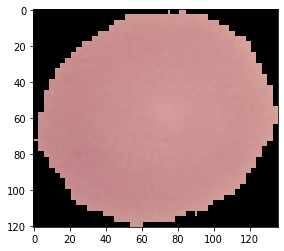

In [31]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[10]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [32]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [33]:
len(os.listdir(train_path+'\\uninfected'))

12480

**Let's find out the average dimensions of these images.**

In [34]:
unifected_cell.shape

(121, 136, 3)

In [35]:
para_img.shape

(154, 154, 3)

In [36]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

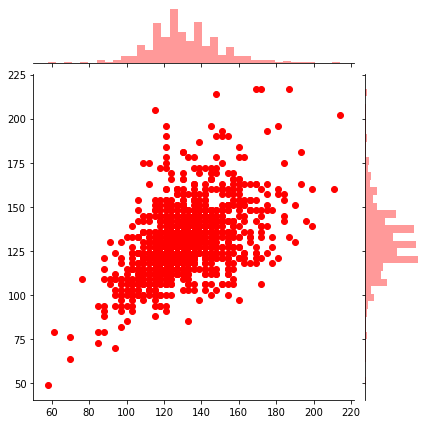

In [41]:
sns.jointplot(dim1,dim2, color='r')

In [42]:
np.mean(dim1)

130.92538461538462

In [43]:
np.mean(dim2)

130.75

In [44]:
image_shape = (130,130,3)

## Preparing the Data for the model

### Image Manipulation
 **ImageDataGenerator** 

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
# help(ImageDataGenerator)

In [50]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

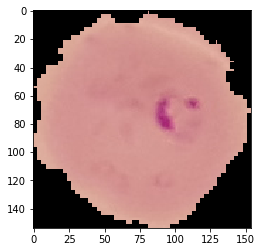

In [51]:
plt.imshow(para_img)

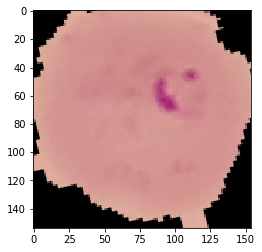

In [52]:
plt.imshow(image_gen.random_transform(para_img))

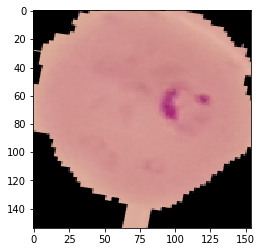

In [53]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory


In [54]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [55]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [57]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here I say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [61]:
# help(image_gen.flow_from_directory)

In [62]:
batch_size = 16

In [63]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [64]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [65]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [66]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.4588 - accuracy: 0.8060 - val_loss: 0.3180 - val_accuracy: 0.9112
Epoch 2/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.2411 - accuracy: 0.9300 - val_loss: 0.1947 - val_accuracy: 0.9412
Epoch 3/20
1560/1560 [==============================] - 95s 61ms/step - loss: 0.2015 - accuracy: 0.9372 - val_loss: 0.1841 - val_accuracy: 0.9423
Epoch 4/20
1560/1560 [==============================] - 98s 63ms/step - loss: 0.1670 - accuracy: 0.9485 - val_loss: 0.1693 - val_accuracy: 0.9431
Epoch 5/20
1560/1560 [==============================] - 98s 63ms/step - loss: 0.1606 - accuracy: 0.9500 - val_loss: 0.1882 - val_accuracy: 0.9388
Epoch 6/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.1583 - accuracy: 0.9514 - val_loss: 0.1464 - val_accuracy: 0.9542
Epoch 7/20
1560/1560 [==============================] - 97s 62ms/step - loss: 0.1559 - accuracy: 0.9497 - val_loss: 0.1595 -

In [88]:
from tensorflow.keras.models import load_model
model.save('malaria_detectorY_B.h5')

# Evaluating the Model

In [89]:
losses = pd.DataFrame(model.history.history)

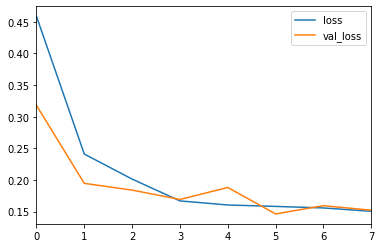

In [90]:
losses[['loss','val_loss']].plot()

In [91]:
model.metrics_names

['loss', 'accuracy']

In [114]:
model.evaluate_generator(test_image_gen)

[0.14881458843521134, 0.94884616]

In [97]:
from tensorflow.keras.preprocessing import image

In [115]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [116]:
pred_probabilities

array([[2.2703409e-04],
       [2.1749735e-04],
       [5.4228306e-04],
       ...,
       [9.7448182e-01],
       [9.7615612e-01],
       [9.6059412e-01]], dtype=float32)

In [117]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [118]:
predictions = pred_probabilities > 0.5

In [119]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [120]:
from sklearn.metrics import classification_report,confusion_matrix

In [121]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [122]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1220,   80],
       [  46, 1254]], dtype=int64)

# Predicting on an Image

In [67]:

para_cell

'C:\\Users\\Yasser B\\Desktop\\Tf2\\TF_2_Notebooks_and_Data\\cell_images\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144348_cell_138.png'

In [132]:
my_image = image.load_img(para_cell,target_size=image_shape)

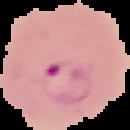

In [137]:
my_image

In [138]:
type(my_image)

PIL.Image.Image

In [139]:
my_image = image.img_to_array(my_image)

In [142]:
type(my_image)

numpy.ndarray

In [143]:
my_image.shape

(130, 130, 3)

In [144]:
my_image = np.expand_dims(my_image, axis=0)

In [145]:
my_image.shape

(1, 130, 130, 3)

In [146]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [147]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [148]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

# DONE!